In [1]:
import glob

from fastai.text import *
# from fastai.callbacks import SaveModelCallback
import sentencepiece as spm #https://github.com/google/sentencepiece

from prod.sp_tok import *

torch.backends.cudnn.enabled=False #for quant.313v machine.  Not sure why...

In [2]:
PATH = Path('./data/rnn')
sp_model = './all_tweets_es_0606'

defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )
mycust_tok = CustomTokenizer(SPTokenizer,sp_model,pre_rules=default_rules)

In [3]:
test_df = pd.read_csv('./data/haha_2019_test.csv')
test_df['is_humor'] = 0
test_df['is_humor'].iloc[0] = 1 #create two classes in data.
## apply the rules
raw_text = test_df.loc[:,'text']

print("Default Rules:\n",[x.__name__ for x in default_rules],"\n\n")
for rule in default_rules:
    raw_text = raw_text.apply(lambda x: rule(str(x)))    
test_df['new_text'] =  raw_text #tokenizer adds xxbos

data_tst = TextClasDataBunch.from_df(PATH, test_df, test_df,
                               tokenizer=mycust_tok, vocab=sp_vocab,
                               text_cols='new_text', label_cols='is_humor')

In [13]:
model_wt_fnames = [x.split('/')[-1] for x in glob.glob( str(PATH/'models')+'/haha_clas*_bwd.pth')]
len(model_wt_fnames)

204

In [14]:
!grep Clas ./prod/out_bwd_tmp1?.txt > ./by_seed_bwd_perf

In [15]:
## be more picky about the models.  Take the top quarter in validation. Does better val -> better test?
valid_perf = pd.read_csv('by_seed_bwd_perf', names = ['id','acc','F1'])
valid_perf['rnd_seed'] = valid_perf.id.str.split(':',expand=True).iloc[:,-1].str.strip()
valid_perf.head()

,id,acc,F1,rnd_seed
0,./prod/out_bwd_tmp10.txt:Clas RndSeed: 18557,0.847222,0.812627,18557
1,./prod/out_bwd_tmp10.txt:Clas RndSeed: 827705,0.847500,0.808599,827705
2,./prod/out_bwd_tmp10.txt:Clas RndSeed: 988722,0.850000,0.810999,988722
3,./prod/out_bwd_tmp10.txt:Clas RndSeed: 376490,0.843611,0.808266,376490
4,./prod/out_bwd_tmp10.txt:Clas RndSeed: 512808,0.846667,0.810309,512808


Text(0.5, 1.0, 'Backward Model \n Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

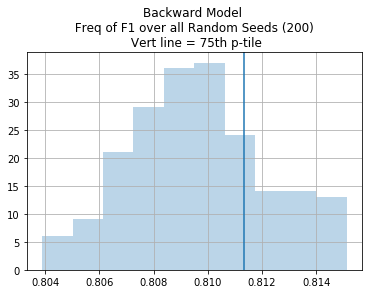

In [18]:
valid_perf.F1.hist(alpha=0.3)
plt.axvline(x=valid_perf.F1.quantile(0.75))
#valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].F1.hist(alpha=0.3)
plt.title('Backward Model \n Freq of F1 over all Random Seeds (200) \n Vert line = 75th p-tile')

In [33]:
selected_rnd_seeds = valid_perf[valid_perf.F1 >= valid_perf.F1.quantile(0.75)].rnd_seed.tolist()

In [37]:
model_wt_fnames = [f'haha_clas{x}.pth' for x in selected_rnd_seeds]

In [38]:
ensemble_preds = []
for wt_fname in model_wt_fnames:
    config = awd_lstm_clas_config.copy()
    config['qrnn'] = True
    config['n_hid'] = 2304
    
    learn = text_classifier_learner(data_tst, AWD_LSTM, drop_mult=0.7,pretrained=False,
                               config=config)
    learn = learn.load(wt_fname.split('.')[0]) #load weights
    preds_t,y_t,losses_t = learn.get_preds(DatasetType.Valid,with_loss=True, ordered=True)
    ensemble_preds.append(to_np(preds_t))

In [39]:
np.array(ensemble_preds).shape

(50, 6000, 2)

In [41]:
np.array(ensemble_preds)

array([[[0.267982, 0.732018],
        [0.892686, 0.107314],
        [0.053149, 0.946851],
        [0.977666, 0.022334],
        ...,
        [0.972737, 0.027263],
        [0.930824, 0.069176],
        [0.482312, 0.517688],
        [0.180876, 0.819124]],

       [[0.277356, 0.722644],
        [0.729095, 0.270905],
        [0.098654, 0.901346],
        [0.907555, 0.092445],
        ...,
        [0.857039, 0.142961],
        [0.917596, 0.082404],
        [0.455641, 0.544358],
        [0.184325, 0.815675]],

       [[0.236542, 0.763458],
        [0.959319, 0.040681],
        [0.056263, 0.943737],
        [0.979277, 0.020723],
        ...,
        [0.978749, 0.021251],
        [0.944061, 0.055939],
        [0.436965, 0.563035],
        [0.205847, 0.794153]],

       [[0.190039, 0.809961],
        [0.940626, 0.059374],
        [0.058404, 0.941596],
        [0.986025, 0.013975],
        ...,
        [0.987029, 0.012971],
        [0.931957, 0.068043],
        [0.638808, 0.361192],
        [0.1

In [42]:
ens_mean = np.array(ensemble_preds).mean(axis=0)
ens_mean

array([[0.220456, 0.779544],
       [0.879834, 0.120166],
       [0.057766, 0.942234],
       [0.955162, 0.044838],
       ...,
       [0.904799, 0.095201],
       [0.927203, 0.072797],
       [0.424851, 0.575149],
       [0.180511, 0.819489]], dtype=float32)

In [43]:
out_df = test_df['id'].to_frame().copy()
out_df['is_humor'] = ens_mean.argmax(axis=1)
out_df['funniness_average'] = 3.

In [44]:
out_df.head()

,id,is_humor,funniness_average
0,tweet1,1,3.0
1,tweet2,0,3.0
2,tweet3,1,3.0
3,tweet4,0,3.0
4,tweet5,0,3.0


In [45]:
out_df.to_csv('sub0606_2.csv',header=True,index=False)